# Comparing direct evolution to mesolve/mcsolve

In [2]:
%matplotlib inline

import numpy as np
from qutip import *
import LH_tools
import matplotlib.pyplot as plt
import adiabatic_sim 
from IPython.display import display



n = 6
N = 2**n


id_n = tensor([qeye(2)]*n)
psi0 = tensor([basis(2,0)]*n)
psi0= hadamard_transform(n)*psi0
H_0 = id_n-psi0*psi0.trans()
rot_H0, rot_psi0 = LH_tools.rotate_by_had(H_0, psi0)
# Generate the state we are looking for
w = tensor([basis(2,0),basis(2,1),basis(2,0),basis(2,0),basis(2,1),basis(2,0)])

#Define final hamiltonian
H_1 = id_n - w*w.trans()

eps = 0.3
s = lambda t : LH_tools.s_function(t,N,eps)
tmax = LH_tools.find_s_one(N,eps)
tlist = np.linspace(0, tmax , 10)

## Compare mcsolve to mesolve

In [3]:
def plot_energies_and_expects(h_s, output, slist, args, figsize=(15, 5), plot_tlist = 'same as tlist'):
    if plot_tlist == 'same as tlist':
        plot_tlist = slist
    hs = [Qobj.evaluate(h_s, t,args) for t in slist]
    eigs = []
    for h in hs:
        eigs.append(h.eigenstates(eigvals=2)[1])

    expects = []
    for eig_pair,psi_t in zip(eigs, output.states):
        expects.append(
            [abs(eig_pair[0].overlap( psi_t))**2,         
            abs(eig_pair[1].overlap( psi_t))**2]
        )
    fig = plt.figure(figsize=figsize)
    P_plt = fig.add_subplot(1, 2, 1)
    P_plt.set_title("Occupation probabilities")
    P_plt.plot(plot_tlist, expects)
    
    ev_plt = fig.add_subplot(1, 2, 2)
    ev_plt.set_title("Eigenvalues")
    ev_plt.plot(plot_tlist, [h.eigenstates(eigvals=2)[0] for h in hs])
    
from scipy.linalg import expm

def sim_simple_adiabatic(tlist, H0, H1, s='linear'):
    """

    :param tlist: Time list
    :param H0: first hamiltonian
    :param H1: second hamiltonian
    :param s: function - relates time to coupling, default is linear dependecy
    :return:
    """
    if s == 'linear':
        s = lambda t: (t - tmin) / (tmax - tmin)
    duration = len(tlist)
    tmin = min(tlist)
    tmax = max(tlist)
    # start at H0 ground state
    eigvals, eigvecs = H0.eigenstates(eigvals=2)
    P_mat = []
    eigvals_mat = []
    psi = eigvecs[0]
    psis = [psi]
    eigvals_mat.append(eigvals)

    P_mat.append(
        [abs(eigvecs[0].overlap(psi)) ** 2,
         abs(eigvecs[1].overlap(psi)) ** 2])
    oldt = tmin
    for t in tlist[1:]:
        dt = oldt - t
        Ht = H0 * (1 - s(t)) + H1 * (s(t))
        eigvals, eigvecs = Ht.eigenstates(eigvals=2)
        U = expm(-1j * Ht.data * dt)
        psi = Qobj(U * psi.data, dims=psi.dims)
        psis.append(psi)
        eigvals_mat.append(eigvals)
        P_mat.append(
            [abs(eigvecs[0].overlap(psi)) ** 2,
             abs(eigvecs[1].overlap(psi)) ** 2])
        oldt = t
    return P_mat, eigvals_mat, psis

## Linear 

In [4]:
#Linear mcsolve
H00 = Qobj(dims=H_0.dims)
h_s= [H00,
      [H_0,'(t_max-t)/t_max'],
     [H_1, 't/t_max']]
tlist = np.linspace(0, tmax , 10)
args= {'t_max':tmax, 'N':N, 'epsilon': eps}

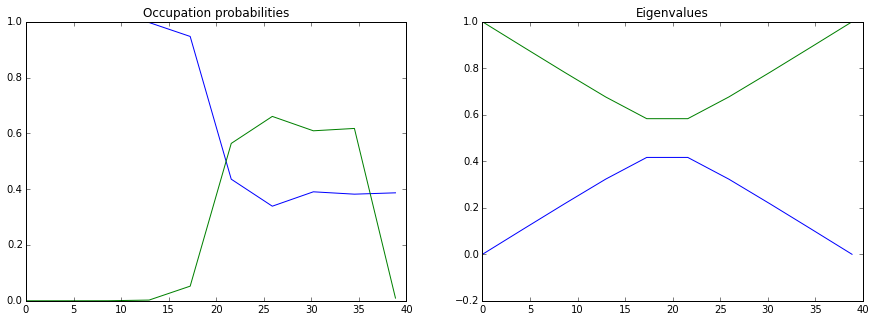

In [5]:
output = qutip.mcsolve(H=h_s,
                       psi0=psi0,
                       tlist=tlist,
                       args=args.copy(),
                       e_ops=[],
                       c_ops=[])

plot_energies_and_expects(h_s, output, tlist, args.copy())

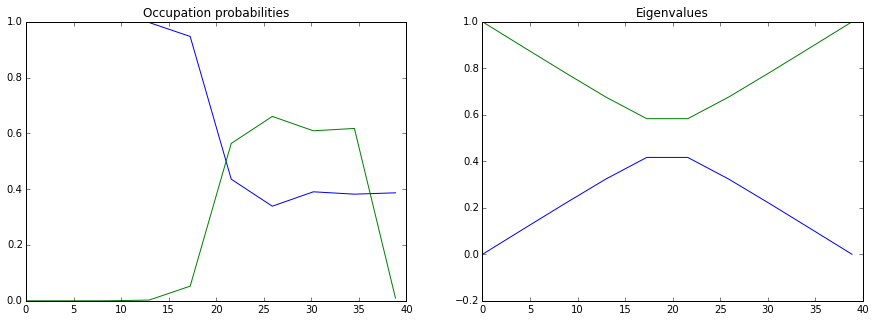

In [6]:
#Linear mesolve
output = qutip.mesolve(H=h_s,
                       rho0=psi0,
                       tlist=tlist,
                       args=args.copy(),
                       e_ops=[],
                      c_ops=[])

plot_energies_and_expects(h_s, output, tlist, {'t_max':tmax, 'N':N, 'epsilon': eps})

/home/oryonatan/anaconda3/envs/qutip/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:243: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/oryonatan/anaconda3/envs/qutip/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:161: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
/home/oryonatan/anaconda3/envs/qutip/lib/python3.5/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


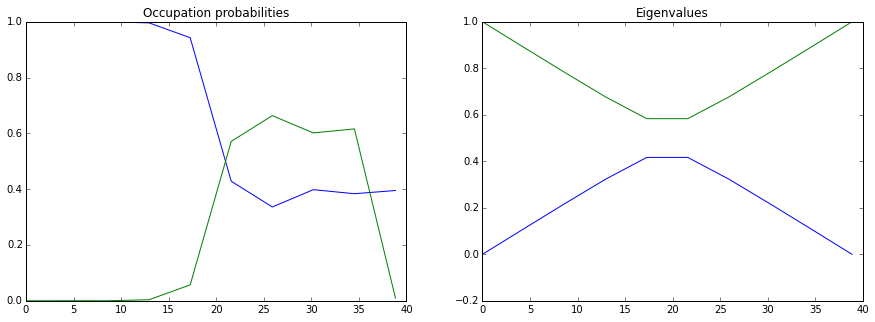

In [7]:
#Linear my implementation

P_mat, evals_mat,psis_sim = sim_simple_adiabatic(tlist, H_0, H_1)
LH_tools.plot_PandEV(P_mat, evals_mat, tlist)
pass

## Roland method one

In [8]:
h_s= [H00,
      [H_0,'(1-1/2*(1-(np.sqrt(N - 1) * np.tan((2 * t * epsilon * np.sqrt(N - 1) - N * np.arctan(np.sqrt(N - 1))) / N))/(1-N)))'],
     [H_1, '(1/2*(1-(np.sqrt(N - 1) * np.tan((2 * t * epsilon * np.sqrt(N - 1) - N * np.arctan(np.sqrt(N - 1))) / N))/(1-N)))']]
tlist = np.linspace(0, tmax , 10)
args = {'t_max':tmax, 'N':N, 'epsilon': eps}

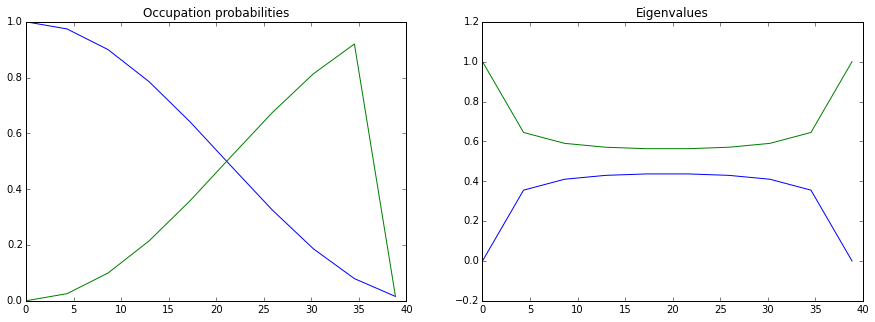

In [9]:
#mcsolve 
output = qutip.mcsolve(H=h_s,
                       psi0=psi0,
                       tlist=tlist,
                       args=args.copy(),
                       e_ops=[],
                      c_ops=[])

plot_energies_and_expects(h_s, output, tlist, args.copy())

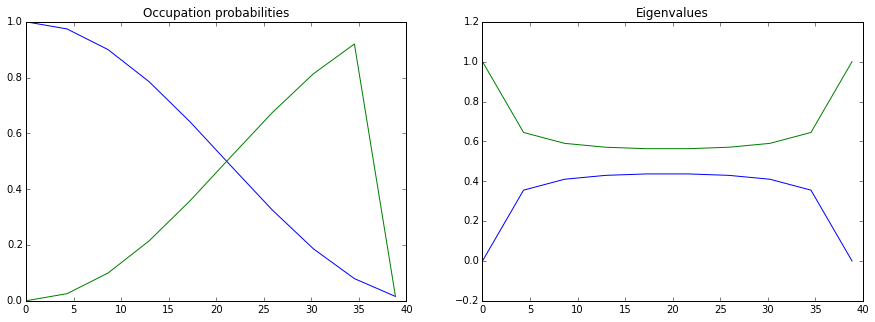

In [10]:
# mesolve
output = qutip.mesolve(H=h_s,
                       rho0=psi0,
                       tlist=tlist,
                       args=args.copy(),
                       e_ops=[],
                      c_ops=[])

plot_energies_and_expects(h_s, output, tlist, args.copy())

/home/oryonatan/anaconda3/envs/qutip/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:243: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/oryonatan/anaconda3/envs/qutip/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:161: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
/home/oryonatan/anaconda3/envs/qutip/lib/python3.5/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


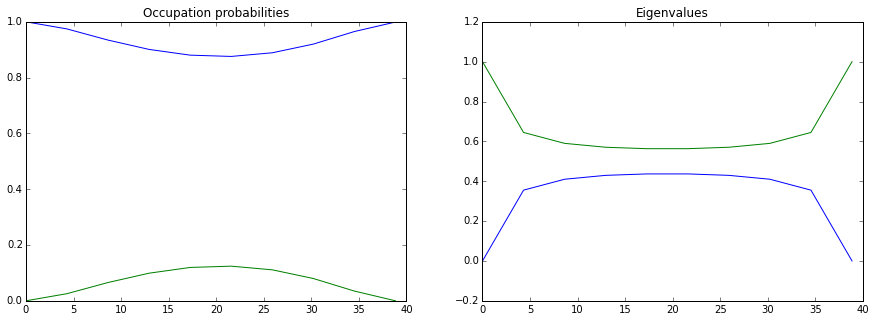

In [11]:
##Using my implementation

s = lambda t : LH_tools.s_function(t,N,eps)
P_mat, evals_mat,psis_sim = adiabatic_sim.sim_simple_adiabatic(tlist, H_0, H_1 ,s)
LH_tools.plot_PandEV(P_mat,evals_mat,tlist)
pass

## Roland method two

In [12]:
H00 = Qobj(dims=H_0.dims)
h_s= [H00,
      [H_0,'(t_max-t)/t_max'],
     [H_1, 't/t_max']]
slist = s(tlist) * tmax

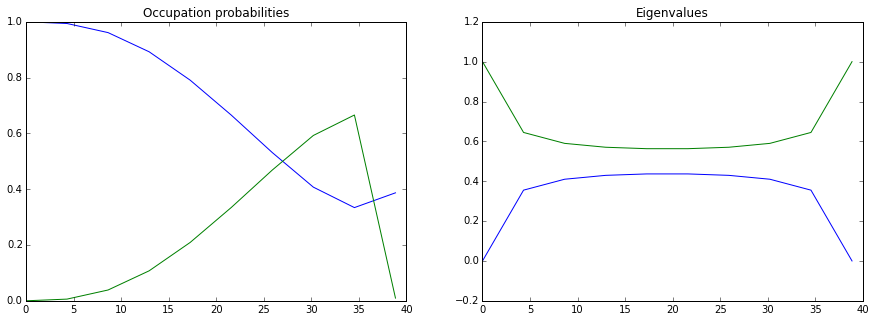

In [13]:
#mcsolve 
output = qutip.mcsolve(H=h_s,
                       psi0=psi0,
                       tlist=slist,
                       args=args.copy(),
                       e_ops=[],
                      c_ops=[])

plot_energies_and_expects(h_s, output, slist, args.copy(),plot_tlist =tlist)

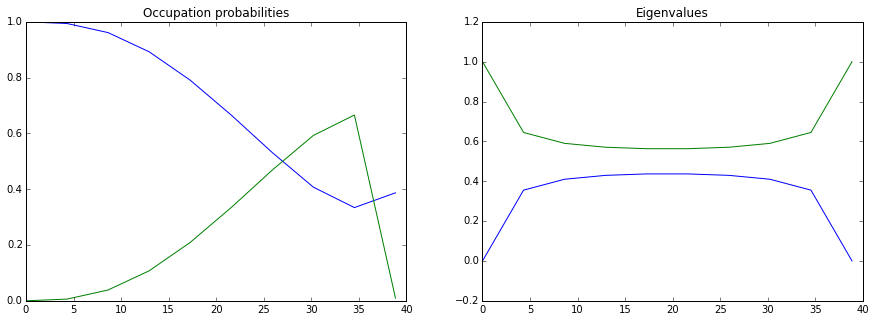

In [14]:
#mesolve 
output = qutip.mesolve(H=h_s,
                       rho0=psi0,
                       tlist=slist,
                       args=args.copy(),
                       e_ops=[],
                      c_ops=[])

plot_energies_and_expects(h_s, output, slist, args.copy(),plot_tlist = tlist)

## Roland method Three

In [15]:
H00 = Qobj(dims=H_0.dims)
h_s= [H00,
      [H_0,'(1-t)'],
     [H_1, 't']]
slist = s(tlist)

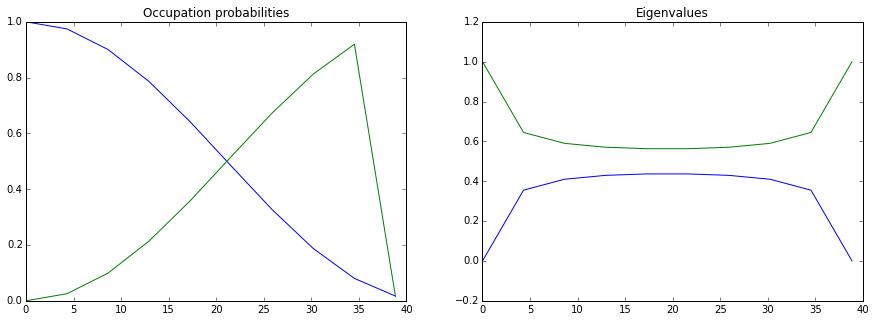

In [16]:
#mcsolve 
output = qutip.mcsolve(H=h_s,
                       psi0=psi0,
                       tlist=slist,
                       args=args.copy(),
                       e_ops=[],
                      c_ops=[])

plot_energies_and_expects(h_s, output, slist, args.copy(),plot_tlist=tlist)

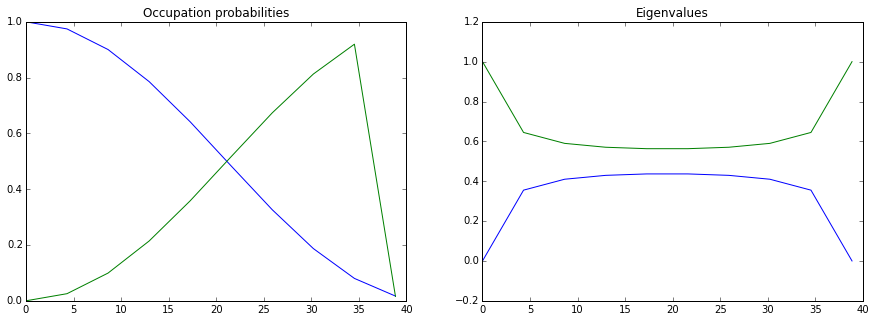

In [17]:
#mesolve 
output = qutip.mesolve(H=h_s,
                       rho0=psi0,
                       tlist=slist,
                       args=args.copy(),
                       e_ops=[],
                      c_ops=[])

plot_energies_and_expects(h_s, output, slist, args.copy(),plot_tlist=tlist)